In [ ]:
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.circuit import ParameterVector, Parameter
import numpy as np
import math

import pickle

import sys
sys.path.append('../../../')
from src import customFunc as cf
from src import ansatzes as anz
from src import variances as var

from qiskit.quantum_info import SparsePauliOp

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Construcción de la QCNN

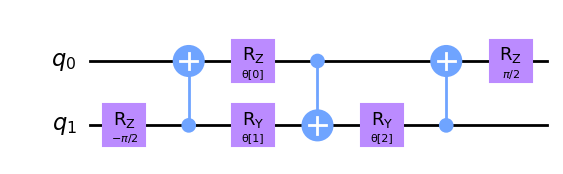

In [5]:
# Definimos la puerta unitaria de dos qubits
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Dibujamos
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

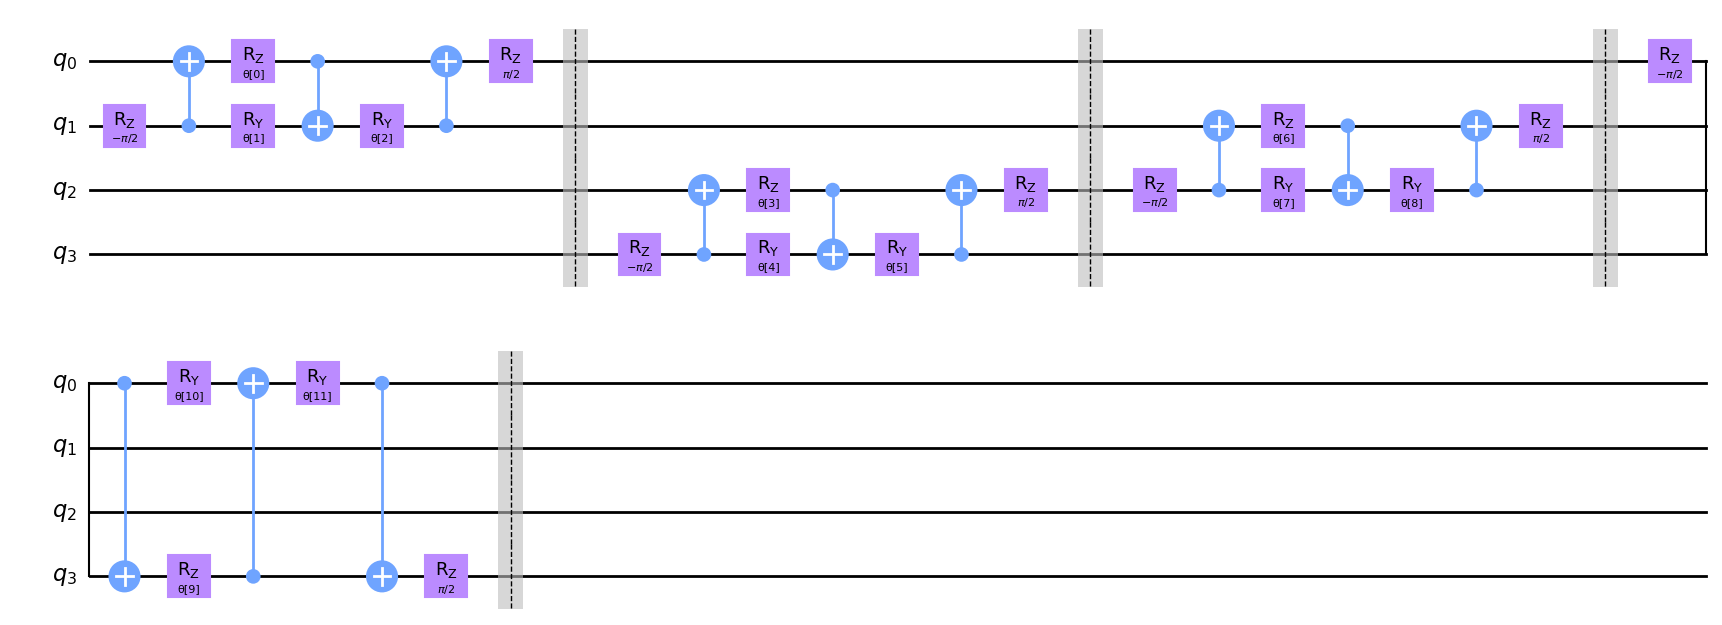

In [6]:
# Definimos la capa convolucional

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Dibujamos
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")


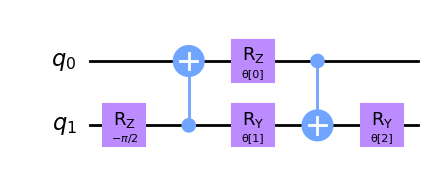

In [7]:
# Definimos la puerta unitaria que transforma el sistema de dos qubits en uno

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

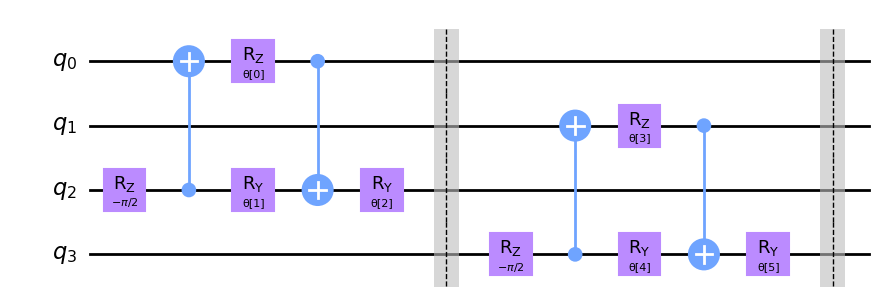

In [8]:
# Definimos la capa de agrupación

def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

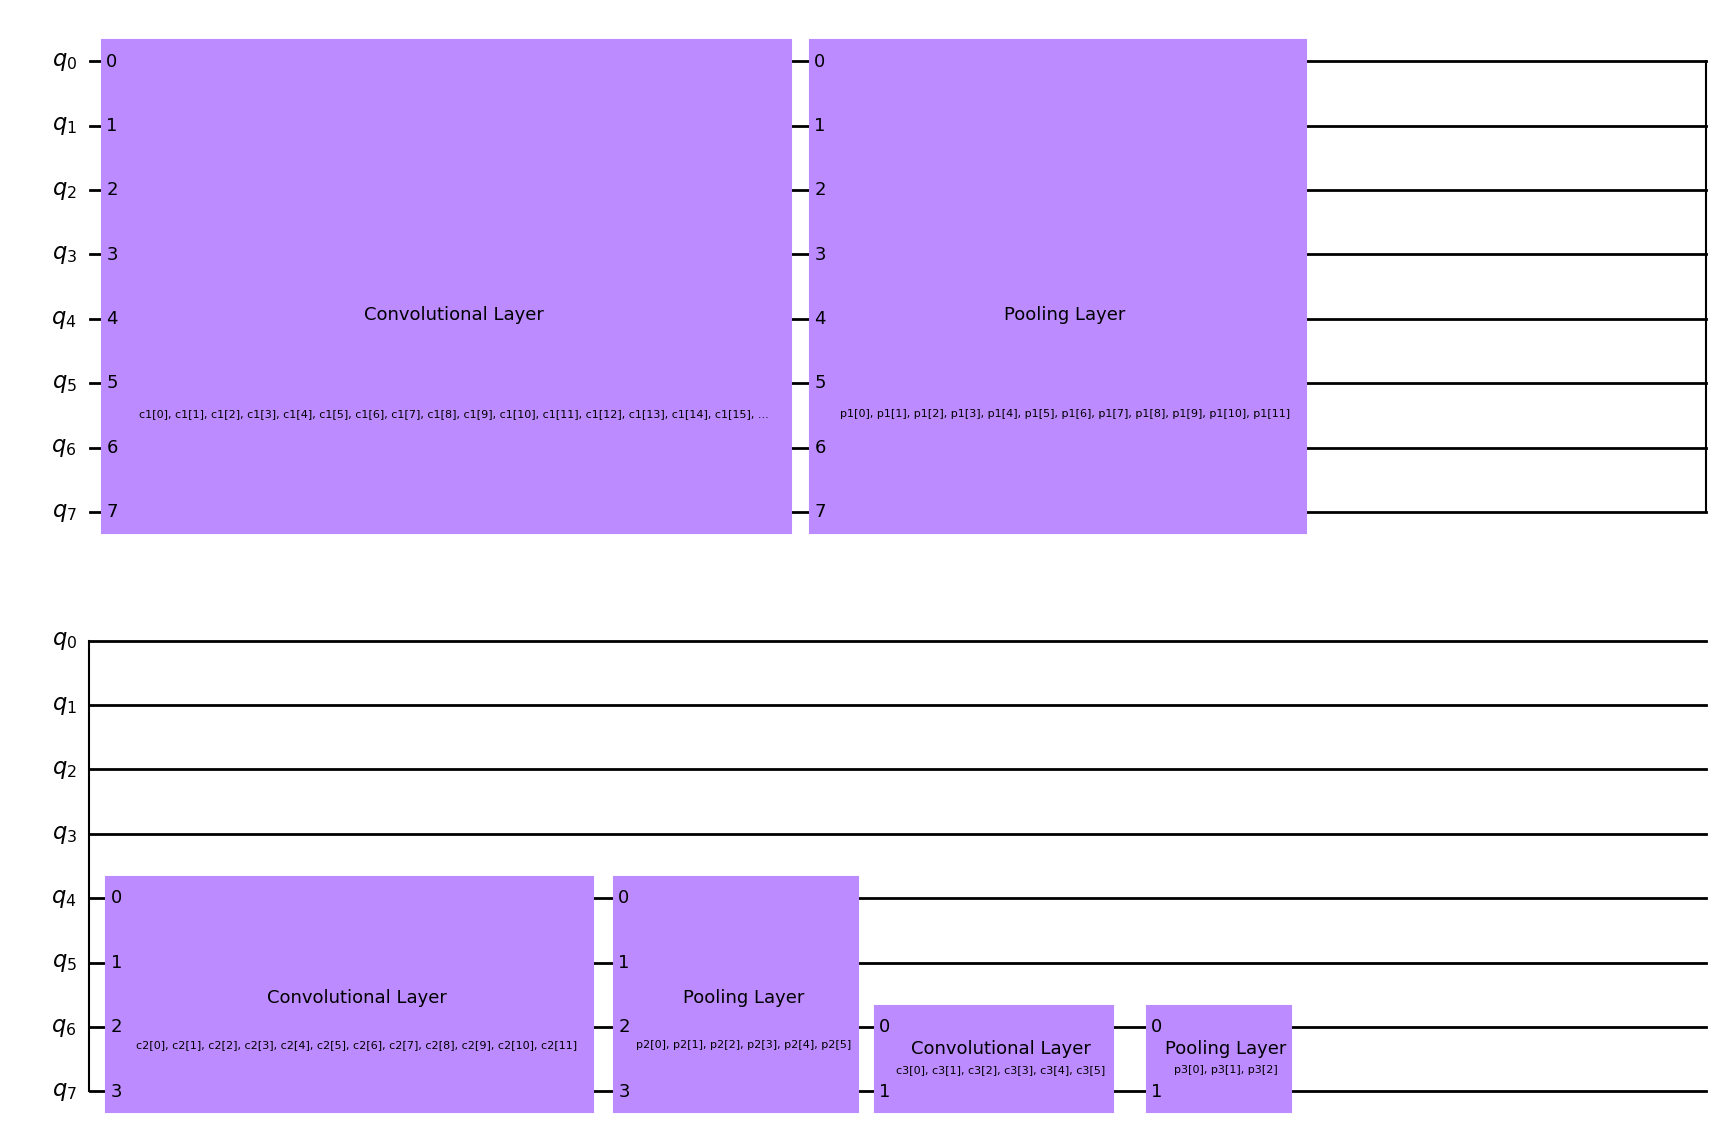

In [21]:
# Definimos la QCNN

def build_qcnn(n_qubits: int) -> QuantumCircuit:
    """
    Crea un circuito QCNN que aplica convolución y pooling de forma jerárquica
    sobre un número de qubits que debe ser potencia de 2.
    """
    if n_qubits < 2 or (n_qubits & (n_qubits - 1)) != 0:
        raise ValueError("El número de qubits debe ser una potencia de 2.")

    qc = QuantumCircuit(n_qubits, name="QCNN")
    depth = int(math.log2(n_qubits))

    for i in range(depth):
        qubits_per_layer = 2 ** (depth - i)
        start = n_qubits - qubits_per_layer
        end = n_qubits

        layer_qubits = list(range(start, end))
        mid = len(layer_qubits) // 2

        # Convolution Layer
        qc.compose(conv_layer(len(layer_qubits), f"c{i+1}"), layer_qubits, inplace=True)

        # Pooling Layer
        sources = list(range(0, mid))
        sinks   = list(range(mid, len(layer_qubits)))
        qc.compose(pool_layer(sources, sinks, f"p{i+1}"), layer_qubits, inplace=True)

    return qc, qc.num_parameters

qc, num_param = build_qcnn(8)
qc.draw("mpl")

### Analizamos las BP

In [22]:
def variance_vs_nQubits(ansantz_function, minQubits: int, maxQubits: int, base_observable,
                        index: int, num_shots: int = 100, print_info: bool = True,
                        plot_info: bool = True, do_regress: bool = False,
                        print_progress: bool = False, use_shift_rule: bool = True,
                        delta: float = 1e-5):

    data = {
        "n_qubits": [],
        "var_value": [],
        "var_deriv": [],
        "value_slope": 0,
        "value_ord": 0,
        "value_rsquare": 0,
        "deriv_slope": 0,
        "deriv_ord": 0,
        "deriv_rsquare": 0
    }

    estimator = Estimator()

    qubits_list = [2**i for i in range(minQubits.bit_length() - 1, maxQubits.bit_length())]

    for n_qubits in qubits_list:

        current_observable = cf.expand_observable(base_observable, n_qubits)
        ansatz_circuit, num_params = ansantz_function(n_qubits)

        if print_info:
            print("\n=====================================================")
            print(f"Calculando varianzas con {n_qubits} qubits.\n")

        var_value, var_deriv = cf.get_variances_data(num_params, ansatz_circuit,
                                                     current_observable, estimator,
                                                     index, num_shots,
                                                     print_progress=print_progress,
                                                     use_shift_rule=use_shift_rule, delta=delta)

        if print_info:
            print(f"Varianza del valor esperado: {var_value}")
            print(f"Varianza de la derivada: {var_deriv}")

        data["n_qubits"].append(n_qubits)
        data["var_value"].append(var_value)
        data["var_deriv"].append(var_deriv)

    # Regresión
    if do_regress and len(data["n_qubits"]) >= 2:
        value_regress = linregress(data["n_qubits"], np.log(data["var_value"]))
        deriv_regress = linregress(data["n_qubits"], np.log(data["var_deriv"]))

        data["value_slope"] = value_regress[0]
        data["value_ord"] = value_regress[1]
        data["value_rsquare"] = value_regress[2] ** 2

        data["deriv_slope"] = deriv_regress[0]
        data["deriv_ord"] = deriv_regress[1]
        data["deriv_rsquare"] = deriv_regress[2] ** 2

        if print_info:
            print("\n=====================================================")
            print(f"Pendiente para valor esperado: {data['value_slope']}.")
            print(f"R^2 para valor esperado: {data['value_rsquare']}.")
            print("\n=====================================================")
            print(f"Pendiente para derivada: {data['deriv_slope']}.")
            print(f"R^2 para derivada: {data['deriv_rsquare']}.")

    # Plot
    if plot_info:
        fig, ax = plt.subplots()

        ax.scatter(data["n_qubits"], data["var_value"], label=r"Var($\langle O\rangle$)")
        ax.scatter(data["n_qubits"], data["var_deriv"], label=rf"Var($\partial_{index}\langle O\rangle$)")

        if do_regress:
            base = np.linspace(min(data["n_qubits"]), max(data["n_qubits"]), 100)
            ax.plot(base, np.exp(data["value_slope"] * base + data["value_ord"]),
                    color="black", label=r"Tendencia: Var($\langle O\rangle$)")
            ax.plot(base, np.exp(data["deriv_slope"] * base + data["deriv_ord"]),
                    color="red", label=rf"Tendencia: Var($\partial_{index}\langle O\rangle$)")

        ax.set_xlabel(r"$N$ qubits")
        ax.set_title(rf"BP en VQE, variando el parámetro $\theta_{index}$")
        ax.set_yscale("log")
        ax.legend()
        plt.show()

    return data



Calculando varianzas con 2 qubits.

Varianza del valor esperado: 0.4731281046626552
Varianza de la derivada: 1.4914401489334757e-32

Calculando varianzas con 4 qubits.

Varianza del valor esperado: 0.14111957833253766
Varianza de la derivada: 2.0605563896377588e-32

Calculando varianzas con 8 qubits.

Varianza del valor esperado: 0.01714615411861062
Varianza de la derivada: 3.9593796816190434e-33

Calculando varianzas con 16 qubits.

Varianza del valor esperado: 0.0012146480701105947
Varianza de la derivada: 1.6048434026758765e-33

Pendiente para valor esperado: -0.4184903604734219.
R^2 para valor esperado: 0.9811097859449247.

Pendiente para derivada: -0.18037824180288026.
R^2 para derivada: 0.8863960231829003.


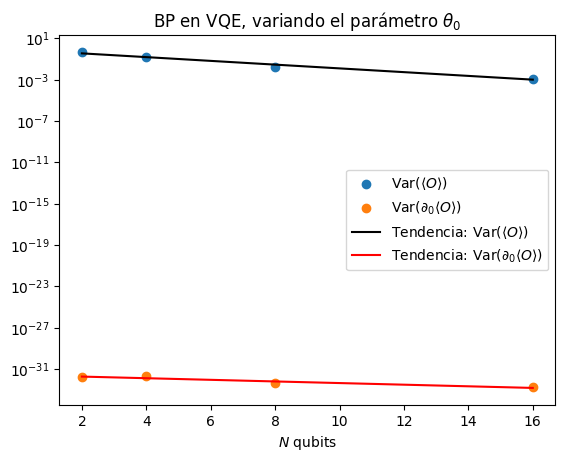

In [24]:
obs  = SparsePauliOp.from_list([("Z",1)])
data = variance_vs_nQubits(build_qcnn, 2, 16, obs, 0, 100, print_info=True, plot_info=True, do_regress=True)